<a href="https://colab.research.google.com/github/ras1364/Fake-Review-Using-BERT/blob/main/FakeReviewDetectionUsingBertVer3_0_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from string import ascii_lowercase
from collections import Counter
import itertools, nltk, snowballstemmer, re

!pip install transformers
import transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
X_test = pd.read_csv("/content/sample_data/X_test.csv")
X_train = pd.read_csv("/content/sample_data/X_train.csv")
y_test = pd.read_csv("/content/sample_data/y_test.csv")
y_train = pd.read_csv("/content/sample_data/y_train.csv")

In [3]:
max_length = 100
# for x in range(0,len(X_train)):
#   line = X_train.loc[x].at["stemmed_text_data"]
#   if max_length < len(line.split()) :
#     max_length = len(line.split())

print(max_length)


150


In [4]:
from transformers import AutoTokenizer, TFBertModel 
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert_model = TFBertModel.from_pretrained('bert-base-uncased')


Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [5]:
def encode(text, maxlen):
  input_ids=[]
  attention_masks=[]

  for row in text:
    encoded = tokenizer.encode_plus(
        row,
        add_special_tokens=True,
        max_length=maxlen,
        pad_to_max_length=True,
        return_attention_mask=True,
    )
    input_ids.append(encoded['input_ids'])
    attention_masks.append(encoded['attention_mask'])

  return np.array(input_ids),np.array(attention_masks)

In [6]:
# X_train_encoded = encode(X_train["stemmed_text_data"].tolist(), maxlen=max_length)
# X_test_encoded = encode(X_test["stemmed_text_data"].tolist(), maxlen=max_length)
X_train_input_ids, X_train_attention_masks = encode(X_train["stemmed_text_data"].tolist(), maxlen=max_length)
X_test_input_ids, X_test_attention_masks = encode(X_test["stemmed_text_data"].tolist(), maxlen=max_length)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2339: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [7]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def build_model(bert_model):
   input_word_ids = tf.keras.Input(shape=(max_length,),dtype='int32')
   attention_masks = tf.keras.Input(shape=(max_length,),dtype='int32')

   sequence_output = bert_model([input_word_ids,attention_masks])
   output = sequence_output[1]
   output = tf.keras.layers.Dense(32,activation='relu')(output)
   output = tf.keras.layers.Dropout(0.2)(output)
   output = tf.keras.layers.Dense(1,activation='sigmoid')(output)

   model = tf.keras.models.Model(inputs = [input_word_ids,attention_masks], outputs = output)
   model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])

   return model

In [8]:
model = build_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 150)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 150,                                           

/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [9]:
history = model.fit(
    [X_train_input_ids, X_train_attention_masks],
    y_train,
    batch_size=32,
    epochs=5,
    validation_data=([X_test_input_ids, X_test_attention_masks], y_test))

Epoch 1/5
35/35 [==============================] - 2066s 58s/step - loss: 0.7010 - accuracy: 0.5080 - val_loss: 0.6901 - val_accuracy: 0.5063
Epoch 2/5
35/35 [==============================] - 1976s 57s/step - loss: 0.6863 - accuracy: 0.5473 - val_loss: 0.6794 - val_accuracy: 0.6021
Epoch 3/5
35/35 [==============================] - 1979s 57s/step - loss: 0.6668 - accuracy: 0.5884 - val_loss: 0.6002 - val_accuracy: 0.6812
Epoch 4/5
35/35 [==============================] - 1985s 57s/step - loss: 0.5392 - accuracy: 0.7330 - val_loss: 0.5048 - val_accuracy: 0.7542
Epoch 5/5
35/35 [==============================] - 1982s 57s/step - loss: 0.4337 - accuracy: 0.8250 - val_loss: 0.4719 - val_accuracy: 0.7875


In [10]:
loss, accuracy = model.evaluate([X_test_input_ids, X_test_attention_masks], y_test)
print('Test accuracy :', accuracy ,' and loss = ', loss)

15/15 [==============================] - 253s 17s/step - loss: 0.4719 - accuracy: 0.7875
Test accuracy : 0.7875000238418579  and loss =  0.4719296395778656


In [12]:
y_predicted = model.predict([X_test_input_ids, X_test_attention_masks])
y_predicted = y_predicted.flatten()

15/15 [==============================] - 269s 18s/step


In [22]:
import numpy as np
y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0,

In [23]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_predicted)
cm 

array([[207,  33],
       [ 69, 171]])

Text(33.0, 0.5, 'Truth')

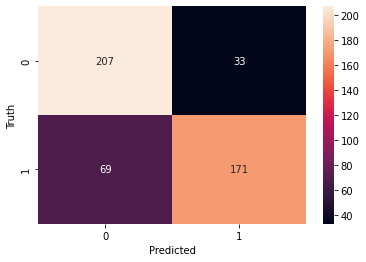

In [24]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [25]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.75      0.86      0.80       240
           1       0.84      0.71      0.77       240

    accuracy                           0.79       480
   macro avg       0.79      0.79      0.79       480
weighted avg       0.79      0.79      0.79       480

